In [53]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [54]:
#The compressed file will be 1/N as big as the original
N = 3; 

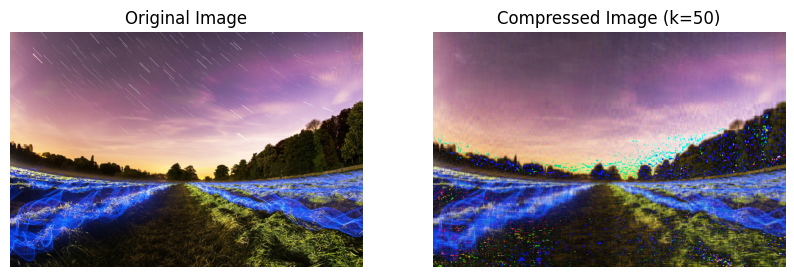

In [55]:
image = Image.open('landscapre_high_res.bmp') 
original_image_size = os.path.getsize('landscapre_high_res.bmp')
image = np.array(image) 

red_channel = image[:,:,0]
green_channel = image[:,:,1]
blue_channel = image[:,:,2]

# Perform SVD compression on one color channel
def compress_one_channel(channel, k):
    U, S, V = np.linalg.svd(channel, full_matrices=False)
    
    U_truncated = U[:, :k]
    S_truncated = np.diag(S[:k])
    V_truncated = V[:k, :]

    return [U_truncated, S_truncated, V_truncated]

def build_diagonal_matrix(diagonal):
    S_mat = np.zeros((k,k))
    for i in range(0, len(diagonal)):
        S_mat[i][i] = diagonal[i]
    return S_mat

# Takes an image converted to numpy array
def compress_the_whole_image(image, k):
    red_channel = image[:,:,0]
    green_channel = image[:,:,1]
    blue_channel = image[:,:,2]
    mat_array = compress_one_channel(red_channel, k) + compress_one_channel(green_channel, k) + compress_one_channel(blue_channel, k)
    np.savez_compressed('compressed.npz',
                        U_red = mat_array[0], S_red = mat_array[1].diagonal(), V_red = mat_array[2],
                        U_green = mat_array[3], S_green = mat_array[4].diagonal(), V_green = mat_array[5],
                        U_blue = mat_array[6], S_blue = mat_array[7].diagonal(), V_blue = mat_array[8], k=[k])

def restore_image(path_to_file):
    intermediate_representation = np.load('compressed.npz')

    U_red = intermediate_representation['U_red']
    S_red = build_diagonal_matrix(intermediate_representation['S_red'])
    V_red = intermediate_representation['V_red']
    U_green = intermediate_representation['U_green']
    S_green = build_diagonal_matrix(intermediate_representation['S_green'])
    V_green = intermediate_representation['V_green']
    U_blue = intermediate_representation['U_blue']
    S_blue = build_diagonal_matrix(intermediate_representation['S_blue'])
    V_blue = intermediate_representation['V_blue']

    k = intermediate_representation['k'][0]
    return [np.stack((U_red @ S_red @ V_red, U_green @ S_green @ V_green, U_blue @ S_blue @ V_blue), axis=-1), k]

# Number of singular values
k = 55
compress_the_whole_image(image, k)

while((original_image_size/(os.path.getsize('compressed.npz'))) <= N):
    k -= 1
    compress_the_whole_image(image, k)

# image + k
image_restoration_result = restore_image("compressed.npz")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title('Original Image')

axs[1].imshow(image_restoration_result[0].astype(np.uint8))
axs[1].set_title(f'Compressed Image (k={image_restoration_result[1]})')

for ax in axs:
    ax.axis('off')

plt.show()